# Machine learning engineer  - тестовое задание, 2024

## Формулировка задачи:

Доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год. Требуется на основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год. 

Доступны 2 выборки: 

- train - выборка для обучения и валидации , 50 тыс. застрахованных с проставленными значениями target.
- holdout - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения target скрыты.

Для оценки качества модели будет применяться метрика MSE.

## Описание данных:

- Insured_PIN - уникальный ид застрахованного лица
- Insured_Network - Идентификатор сети клиник доступной для застрахованного. Network - 1 - клиники с наивысшим уровнем сервиса, Network - 8 - клиники с самым базовым уровнем сервиса.
- Nationality - национальность застрахованного.
- Gender - пол застрахованного
- Relation - в качестве кого застраховано данное лицо. self - работник организации, которая оформляет страховку, child - ребенок застрахованного и т.д.
- DoB - дата рождения застрахованного
- Diagnoses - все диагнозы застрахованного за 2022 год
- HasChronicDisease - флаг хронического пациента
- Exposition_22 - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
- number_of_visits_22 - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
- number_of_services_22 - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
- Exposition_23 - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
- **Target -** number_of_visits_23 - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. **Этот показатель требуется предсказать.**

## Что будет оцениваться:

- Точность модели на выборке holdout (MSE)
- Корректность применения использованных инструментов
- Корректность валидации и тестирования модели
- Оптимальность кода
- Оформление и полнота отчета о тестировании модели

## Оглавление
* [Подготовка к работе](#по_кр)
* [Загрузка и обзор данных](#за_об)
* [Исследовательский анализ данных](#ис_ан)
* [ML](#мл)
    * [Подготовка данных](#по_да)
    * [Подготовка пайплайнов](#по_па)
    * [baseline](#бэ)
    * [Предположение 1: удаление `Exposition_22` и `Exposition_23` позволит точнее определять количество посещений](#п1)
    * [Предположение 2: удаление выбросов позволит точнее определять количество посещений](#п2)
    * [Предположение 3: удаление `Insured_Network` и `Nationality` позволит точнее определять количество посещений](#п3)
    * [Предположение 4: использование `Diagnoses` позволит точнее определять количество посещений](#п4)
    * [Предположение 5: применение tf-idf к `Diagnoses` позволит точнее определять количество посещений](#п5)
    * [Предположение 6: логарифмированние целевой переменной](#п6)
    * [Предположение 7: создание ансамбля](#п7)
    * [Предположение 8: подбор гиперпараметров](#п8)
* [Финальная решение](#фи_ре)
    * [Подготовка данных и модели](#по_да)
    * [Важность признаков](#ва_пр)
    * [Анализ ошибок](#ан_ош)
    * [Подготовка `holdout` выборки](#по_хо)

## Подготовка к работе <a class="anchor" id="по_кр"></a>

Импортируем нужные библиотеки, зададим значения констант и опишем функции.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import phik

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.pipeline import Pipeline, make_pipeline

from lightgbm import LGBMRegressor

from IPython.display import Markdown, display

import warnings
import pickle
import os

In [2]:
sns.set_palette("flare")
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 654321
VAL_SIZE = 0.3
CV = 5
SCORING = 'neg_mean_squared_error'
LOAD_DATA = False

In [4]:
def plot_histogram(df, cols, num_features=True):
    """
    Строит гистограммы для указанных столбцов в датафрейме.

    Параметры:
    -----------
    df : DataFrame
        Датафрейм, содержащий данные для визуализации.
    cols : list
        Список названий столбцов, для которых будут построены гистограммы.
    num_features : bool, по умолчанию True
        Если True, строит распределение числовых признаков; если False, строит распределение категориальных признаков.

    Возвращает:
    -----------
    None
        Функция отображает гистограммы для указанных столбцов, но не возвращает значения.

    Примечания:
    -----------
    Если количество столбцов больше 5, графики будут отображаться на нескольких фигурах,
    чтобы улучшить читаемость.
    """
    
    plt.figure(figsize=(12, 3));
    for i, col in enumerate(cols):
        plt.subplot(1, len(cols), i % len(cols) + 1)
        bins = df[col].nunique()
        sns.histplot(df[col], bins=bins, discrete=True)
        if num_features:
            plt.title(f'Распределение {col}')
            plt.ylabel('Частота')
        else:
            plt.title(f'Количество {col}')
            plt.ylabel('Количество')
            plt.xticks(rotation=60, fontsize=10)
        plt.xlabel(col)
        
        if (i % 5 == 4 or i == len(cols) - 1) and i != 0:
            plt.tight_layout()
            plt.show()
            plt.figure(figsize=(15, 5));

In [5]:
def plot_boxplot_and_histogram_multiple(df, columns):
    """
    Строит боксплоты и гистограммы для заданных столбцов в датафрейме.

    Параметры:
    -----------
    df : DataFrame
        Исходный датафрейм, содержащий данные для визуализации.
    columns : list
        Список строковых названий столбцов, для которых будут построены графики.

    Возвращает:
    -----------
    None
        Функция отображает боксплоты и гистограммы для указанных столбцов, но не
        возвращает значения.

    Примечания:
    -----------
    Если количество указанных столбцов нечётное, последний график
    в последнем столбце будет скрыт.
    """    
    num_columns = len(columns)
    num_rows = num_columns // 2 + num_columns % 2

    fig, axs = plt.subplots(num_rows*2, 2, figsize=(12, 5*num_rows), gridspec_kw={'height_ratios': num_rows*[1, 2]})

    for i, column in enumerate(columns):
        row_index = 2 * (i // 2)
        col_index = i % 2
        
        sns.boxplot(df[column], orient='h', ax=axs[row_index, col_index])
        axs[row_index, col_index].set_title(f'Боксплот столбца {column}')
        axs[row_index, col_index].set_xlabel(column)

        sns.histplot(df[column], bins=df[column].nunique(), ax=axs[row_index+1, col_index])
        axs[row_index+1, col_index].set_title(f'Гистограмма столбца {column}')
        axs[row_index+1, col_index].set_xlabel(column)
        axs[row_index+1, col_index].set_ylabel('Частота')

    if num_columns % 2 != 0:
        axs[-2, -1].axis('off')
        axs[-1, -1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
def count_unique_chars(row):
    """
    Подсчитывает количество уникальных буквенных символов в строке.

    Параметры:
    -----------
    row : str или int
        Строка, в которой нужно подсчитать уникальные буквенные символы.

    Возвращает:
    -----------
    int
        Количество уникальных буквенных символов в строке.
        Если входное значение в строке не является списком, возвращает 0.

    Примечания:
    -----------
    Функция игнорирует все не буквенные символы и учитывает только алфавитные символы.
    Регистры не различаются, то есть 'A' и 'a' считаются одним и тем же символом.
    """
    if not isinstance(row, list):
        return 0
    filtered_chars = set(filter(str.isalpha, row))
    return len(filtered_chars)

In [7]:
def regplots(df, columns):
    """
    Строит регрессионные графики для указанных столбцов в датафрейме, визуализируя взаимосвязь
    между ними и числом посещений.

    Параметры:
    -----------
    df : DataFrame
        Датафрейм, содержащий данные для визуализации. Ожидается, что в нем присутствует колонка
        'number_of_visits_23', представляющая количество посещений за 2023 год.
    columns : list
        Список названий столбцов, для которых будут построены регрессионные графики.

    Возвращает:
    -----------
    None
        Функция отображает регрессионные графики для указанных столбцов, но не возвращает значений.

    Примечания:
    -----------
    Каждый подграфик показывает распределение выбранного признака по оси X и количество посещений по оси Y.
    Используются маркеры и линия регрессии для визуализации трендов.
    Если количество столбцов больше одного, графики отображаются в одном ряду.
    """
    
    num_columns = len(columns)
    
    fig, ax = plt.subplots(1, num_columns, figsize=(12, 4))
    fig.subplots_adjust(wspace=0.3)

    for i, col in enumerate(columns):
        sns.regplot(x=df[col], y=df['number_of_visits_23'], ax=ax[i], marker='o',
                    scatter_kws={'s': 1}, line_kws={'lw': 1, 'color': 'red'})

In [8]:
def target_agg(df, col):
    """
    Выполняет агрегацию данных по заданному столбцу и отображает статистические показатели
    для количества посещений.

    Параметры:
    -----------
    df : DataFrame
        Датафрейм, содержащий данные для агрегации. Ожидается, что в нем присутствует колонка 
        'number_of_visits_23', представляющая количество посещений за 2023 год.
    col : str
        Название столбца, по которому будет выполнена агрегация.

    Возвращает:
    -----------
    None
        Функция отображает таблицу со статистическими показателями, но не возвращает значений.

    Примечания:
    -----------
    Для каждого уникального значения в указанном столбце возвращаются среднее значение,
    стандартное отклонение и общее количество посещений. Результаты сбрасываются в новый датафрейм
    для удобства отображения.
    """
    display(df.groupby(col)['number_of_visits_23'].agg(
        mean_visits='mean',
        std_visits='std',
        count_visits='count'
    ).reset_index())

In [9]:
def heatmap(df):
    """
    Строит тепловую карту корреляций между признаками в датафрейм, используя метод phi-k.

    Параметры:
    -----------
    df : DataFrame
        Датафрейм, содержащий данные для анализа. Ожидается, что в нем содержатся численные 
        и категориальные признаки для вычисления корреляций.

    Возвращает:
    -----------
    None
        Функция отображает тепловую карту, но не возвращает значений.

    Примечания:
    -----------
    Тепловая карта отображает значения корреляции между признаками на уровне от -1 до 1,
    где -1 указывает на полное отрицательное взаимодействие, а 1 - на полное положительное.
    Значения аннотированы на тепловой карте с заданными параметрами шрифта.
    """

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df.phik_matrix(),
        vmin=-1,
        vmax=1,
        linewidths=1,
        annot=True,
        annot_kws={"fontsize": 11, "fontweight": "bold"},
        fmt=".2f",
    )

In [10]:
class CustomColumnTransformer(BaseEstimator, TransformerMixin):
    """
    Пользовательский трансформер для обработки категориальных и числовых признаков в данных.
    
    Атрибуты:
    categorical_columns: Список столбцов, содержащих категориальные признаки.
    numerical_columns: Список столбцов, содержащих числовые признаки.
    """
    
    def init(self):
        self.categorical_columns = None
        self.numerical_columns = None

    def fit(self, X, y=None):
        """
        Определяет категориальные и числовые столбцов во входных данных.
        
        Аргументы:
        X (array-like): Входные данные
        
        Возвращает:
        self: Возвращает экземпляр трансформера
        """
        X_df = pd.DataFrame(X)
        self.categorical_columns = X_df.select_dtypes(include=['category', 'object']).columns.tolist()
        self.numerical_columns = X_df.select_dtypes(include=[np.number]).columns.tolist()
        return self
        
    def cat_feature(self, X):
        """
        Получает список категориальных столбцов признаков.
        
        Аргументы:
        X (array-like): Входные данные
        
        Возвращает:
        list: Список имен столбцов, содержащих категориальные признаки
        """
        self.fit(X)
        return self.categorical_columns

    def num_feature(self, X):
        """
        Получает список числовых столбцов признаков.
        
        Аргументы:
        X (array-like): Входные данные
        
        Возвращает:
        list: Список имен столбцов, содержащих числовые признаки
        """
        self.fit(X)
        return self.numerical_columns
        
    def transform(self, X):
        """
        Преобразует категориальные столбцы в тип 'str'.
        
        Аргументы:
        X (array-like): Входные данные
        
        Возвращает:
        pandas DataFrame: Трансформированные данные с категориальными столбцами в формате 'str'
        """
        self.fit(X)
        X_df = pd.DataFrame(X).copy()
        X_df[self.categorical_columns] = X_df[self.categorical_columns].astype('str')
        return X_df

    def to_category(self, X):
        """
        Преобразует категориальные столбцы в тип 'category'.
            
        Аргументы:
        X (array-like): Входные данные
            
        Возвращает:
        X_copy: Копия входных данных с преобразованными категориальными столбцами
        """
        X_copy = X.copy()
        self.fit(X_copy)
        X_copy[self.categorical_columns] = X_copy[self.categorical_columns].astype('category')
        return X_copy

In [11]:
def metric(model, X_train, y_train, X_val, y_val, scoring=None, need_display=False, need_return=True):
    """
    Функция для вычисления метрик на кросс-валидации и валидационной выборке.

    Параметры:
    -----------
    model : object
        Обучаемая модель, реализующая методы fit и predict.
    X_train : array-like
        Матрица признаков для обучающей выборки.
    y_train : array-like
        Целевая переменная для обучающей выборки.
    X_val : array-like
        Матрица признаков для валидационной выборки.
    y_val : array-like
        Целевая переменная для валидационной выборки.
    scoring : str, optional
        Метрика для оценки, которую следует использовать при кросс-валидации (например, 'neg_mean_squared_error').
        Если None, используется стандартная метрика, определяемая моделью.
    need_display : bool, optional
        Флаг для отображения метрик. По умолчанию False.
    need_return : bool, optional
        Флаг для возвращения метрик. По умолчанию True.

    Возвращает:
    -----------
    tuple (metric_cv, metric_val) или None
        metric_cv : float
            Значение метрики на кросс-валидации.
        metric_val : float
            Значение метрики на валидационной выборке.
        Если need_return = False, возвращает None.
    """
    
    results = cross_validate(model, X_train, y_train, cv=CV, scoring=scoring)
    metric_cv = abs(results["test_score"].mean().round(2))

    model.fit(X_train, y_train)
    pred = model.predict(X_val)

    metric_val = mean_squared_error(y_val, pred).round(2)

    if need_display:
        display(Markdown(f'Метрика на кросс-валидации: **{metric_cv}**'))
        display(Markdown(f'Метрика на валидационной выборке: **{metric_val}**'))

    if need_return:
        return metric_cv, metric_val

In [12]:
def hypothesis_check(models, X_train, y_train, X_val, y_val, hypothesis_name, results):
    """
    Функция для проверки гипотез с использованием различных конвейеров обработки данных и моделей.

    Параметры:
    -----------
    X_train : array-like
        Матрица признаков для обучающей выборки.
    y_train : array-like
        Целевая переменная для обучающей выборки.
    X_val : array-like
        Матрица признаков для валидационной выборки.
    y_val : array-like
        Целевая переменная для валидационной выборки.
    hypothesis_name : str
        Имя гипотезы, которое будет использовано для индексации результатов.
    results : DataFrame
        DataFrame, содержащий результаты для каждой гипотезы и модели.

    Возвращает:
    -----------
    results : DataFrame
        Датафрейм с обновлёнными значениями метрик кросс-валидации и валидационной выборки для данной гипотезы.
    """
    for name, model in models.items():
        results.loc[hypothesis_name, name+'_cv'], results.loc[hypothesis_name, name+'_val'] = metric(model, X_train, y_train, X_val, y_val, scoring=SCORING)
        results.fillna('***')
    return results

In [13]:
def plot_residuals(y_true, y_pred, ax, title, x_lim=None, y_lim=None):
    """
    Строит график остатков (разностей между истинными и предсказанными значениями) на заданной оси.

    Параметры:
    -----------
    y_true : array-like
        Массив с истинными значениями целевой переменной.
        
    y_pred : array-like
        Массив с предсказанными значениями целевой переменной.
        
    ax : matplotlib.axes.Axes
        Объект оси, на которой будет строиться график.
        
    title : str
        Заголовок графика, который отображается на верхней части.
        
    x_lim : tuple, необязательный
        Параметры ограничения оси X формата (min, max).
        
    y_lim : tuple, необязательный
        Параметры ограничения оси Y формата (min, max).

    Возвращает:
    -----------
    None
        Функция отображает график остатков, но не возвращает значений.

    Примечания:
    -----------
    На графике отображаются остатки, рассчитанные как разность между истинными и предсказанными
    значениями. Горизонтальная линия на уровне 0 указывает на отсутствие остатков. Настройка
    пределов по осям X и Y позволяет лучше визуализировать данные, что может быть полезно
    для анализа качества модели.
    """
    residuals = y_true - y_pred
    ax.scatter(y_pred, residuals, alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_xlabel('Предсказанные значения')
    ax.set_ylabel('Остатки')
    ax.set_title(title)
    if x_lim:
        ax.set_xlim(x_lim)
    if y_lim:
        ax.set_ylim(y_lim)

In [14]:
def hist_residuals(y_val, y_pred, ax, x_lim=None):
    """
    Строит гистограмму остатков (разностей между истинными и предсказанными значениями).

    Параметры:
    -----------
    y_val : np.ndarray или pd.Series
        Массив или серия с истинными значениями целевой переменной.
        
    y_pred : np.ndarray или pd.Series
        Массив или серия с предсказанными значениями целевой переменной.
        
    ax : matplotlib.axes.Axes
        Объект оси, на которой будет строиться график. Если параметр не указан, создается новая ось.
        
    x_lim : tuple, необязательный
        Параметры ограничения по оси X в формате (min, max).

    Возвращает:
    -----------
    None
        Функция отображает гистограмму остатков, но не возвращает значений.

    Примечания:
    -----------
    Гистограмма отображает распределение остатков, что может помочь в оценке качества
    модели. Чаще всего остатки должны быть распределены нормально с центром около нуля,
    что указывает на адекватность модели. Установка пределов по оси X позволяет избежать
    искажения графика при наличии выбросов.
    """
    
    residuals = y_val - y_pred
    
    ax.hist(residuals, bins=100, color='blue', alpha=0.7)
    ax.set_xlabel('Остатки')
    ax.set_ylabel('Частота')
    ax.set_title('Гистограмма остатков')
    if x_lim:
        ax.set_xlim(x_lim)

In [15]:
def permutation_importance_cv(model, X, y, cv=7, scoring=None, n_repeats=5, random_state=None, load_data=False):
    '''Функция считает перестановочную важность признаков на кросс-валидации.
    
    Параметры
    ---------
    model : object
        Модель машинного обучения, для которой нужно оценить важность признаков.
    
    X : DataFrame
        Матрица признаков.
    
    y : Series
        Целевая переменная.
    
    cv : int, по умолчанию=7
        Количество фолдов для кросс-валидации.
    
    scoring : str, callable, list, tuple, или dict, по умолчанию=None
        Метод оценки для перестановочной важности.

    n_repeats : int, по умолчанию=5
        Количество повторений по перестановке признака.
    
    random_state : int, по умолчанию=None
        Параметр для инициализации генератора случайных чисел.

    load_data : bool, по умолчанию=False
        Флаг, указывающий, нужно ли загружать данные. Если True, то данные будут загружены из файла.
        Если False, данные не будут загружены.
    
    Возвращает
    -------
    dict
        Словарь с оценками перестановочной важности признаков 
        (importances_mean - средние значения важности, importances - все оценки по итерациям).
    '''
    
    directory = '../results/'
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    if load_data:
        with open('../results/permutation_importance_cv.pickle', 'rb') as f:
            result_pi_dict = pickle.load(f)

    else:
        result_pi = []
        result_pi_dict = {}
    
        stratified_kfold = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        
        for train_index, test_index in stratified_kfold.split(X, y):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
            model.fit(X_train, y_train)
            
            result = permutation_importance(model, X_test, y_test, scoring=scoring, n_repeats=n_repeats, random_state=random_state)
            result_pi.append(result.importances_mean)
    
        result_pi = np.array(result_pi)
        
        result_pi_dict['importances_mean'] = np.mean(result_pi.T, axis=1)
        result_pi_dict['importances'] = result_pi.T

        with open('../results/permutation_importance_cv.pickle', 'wb') as f:
            pickle.dump(result_pi_dict, f)

    return result_pi_dict

In [16]:
def permutation_importance_graph(result, X):
    '''Функция строит график важности признаков на основе результатов перестановочной важности.
    
    Параметры
    ------------
    result : dict
        Словарь с оценками перестановочной важности признаков
        (importances_mean - средние значения важности, importances - все оценки по итерациям).
    
    X : DataFrame
        Матрица признаков.
    '''
    
    sorted_idx = result['importances_mean'].argsort()
    
    fig, ax = plt.subplots(figsize=(12, 0.3 * len(sorted_idx)))
    ax.boxplot(result['importances'][sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Важность признаков на кросс-валидации", fontsize=16)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xlabel("Важность признаков", fontsize=12)
    fig.tight_layout()
    plt.show()

## Загрузка и обзор данных <a class="anchor" id="за_об"></a>

Загрузим данные.

In [17]:
df = pd.read_excel('../data/ML_train.xlsx')

Исходя из описания данных, в столбце `DoB` находится дата рождения. С этим признаком не очень удобно работать. Сразу заменим его полным возрастом клиента и удалим `DoB`. Так же исходя из описания данных признак `Insured_PIN` является уникальным для каждой записи и не несёт информации. Удалим и его.

In [18]:
df['Age'] = 2022 - df.DoB.dt.year

In [19]:
df.drop(['Insured_PIN', 'DoB'], axis=1, inplace=True)

Посмотрим на данные.

In [20]:
df.head()

,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age
0,Network-4,Group 2,Male,Self,NaN,0,365,0,0,365,0,48.0
1,Network-2,Saudi,Female,Child,J20.9;J02,0,365,1,2,365,4,5.0
2,Network-5,Group 2,Male,Self,J03.9,0,365,1,4,365,5,43.0
3,Network-1,Saudi,Male,Self,E56.9;J02;J00,1,365,3,18,365,11,37.0
4,Network-3,Group 3,Male,Self,NaN,0,365,0,0,365,0,60.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Insured_Network        50000 non-null  object 
 1   Nationality            50000 non-null  object 
 2   Gender                 50000 non-null  object 
 3   Relation               50000 non-null  object 
 4   Diagnoses              41226 non-null  object 
 5   HasChronicDisease      50000 non-null  int64  
 6   Exposition_22          50000 non-null  int64  
 7   number_of_visits_22    50000 non-null  int64  
 8   number_of_services_22  50000 non-null  int64  
 9   Exposition_23          50000 non-null  int64  
 10  number_of_visits_23    50000 non-null  int64  
 11  Age                    49999 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 4.6+ MB


In [22]:
df.describe()

,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,49999.000000
mean,0.337940,358.898960,5.740320,22.477420,355.588420,5.898860,32.365907
std,0.473013,35.562003,6.592556,29.714146,43.779065,6.856904,22.741768
min,0.000000,50.000000,0.000000,0.000000,50.000000,0.000000,0.000000
25%,0.000000,365.000000,1.000000,3.000000,365.000000,1.000000,11.000000
50%,0.000000,365.000000,4.000000,13.000000,365.000000,4.000000,31.000000
75%,1.000000,365.000000,8.000000,31.000000,365.000000,8.000000,51.000000
max,1.000000,365.000000,151.000000,962.000000,365.000000,202.000000,102.000000


Отличные данные, проблем не так много:
1. Один пропуск в столбце `Age`, который заполним медианой и пропуски в столбце `Diagnoses` заполним `-1`.
2. Значения в столбцах `Exposition_22` и `Exposition_23` очень сильно смещены к `365` - полному году действия страхового полиса. Возможно столбцы с таким распределением будут не информативны.
3. `962` в `number_of_services_22` выглядит подозрительно.
4. `102` в `Ages`. Средняя продолжительность в (спойлер) Саудовской Аравии - 76 лет (в зависимости от источника), вполне возможно, что у страховой компании есть клиенты с таким возрастом.

Отдельно стоит отметить, что наша целевая переменная - дискретная. Однако в данном исследовании она будет рассматриваться как обычная непрерывная перенная.

Остальные столбцы вопросов не вызывают. Заполним пропуски и приступим к **EDA**.

In [23]:
df.Diagnoses.fillna(-1, inplace=True)
df.Age.fillna(df.Age.median(), inplace=True)

## Исследовательский анализ данных <a class="anchor" id="ис_ан"></a>

В этом разделе мы изучим данные, исследуем закономерности и наметим предположения, которые могут повысить точность предсказаний. 

Для числовых столбцов построим боксплоты и гистограммы, для категориальных - только гистограммы.

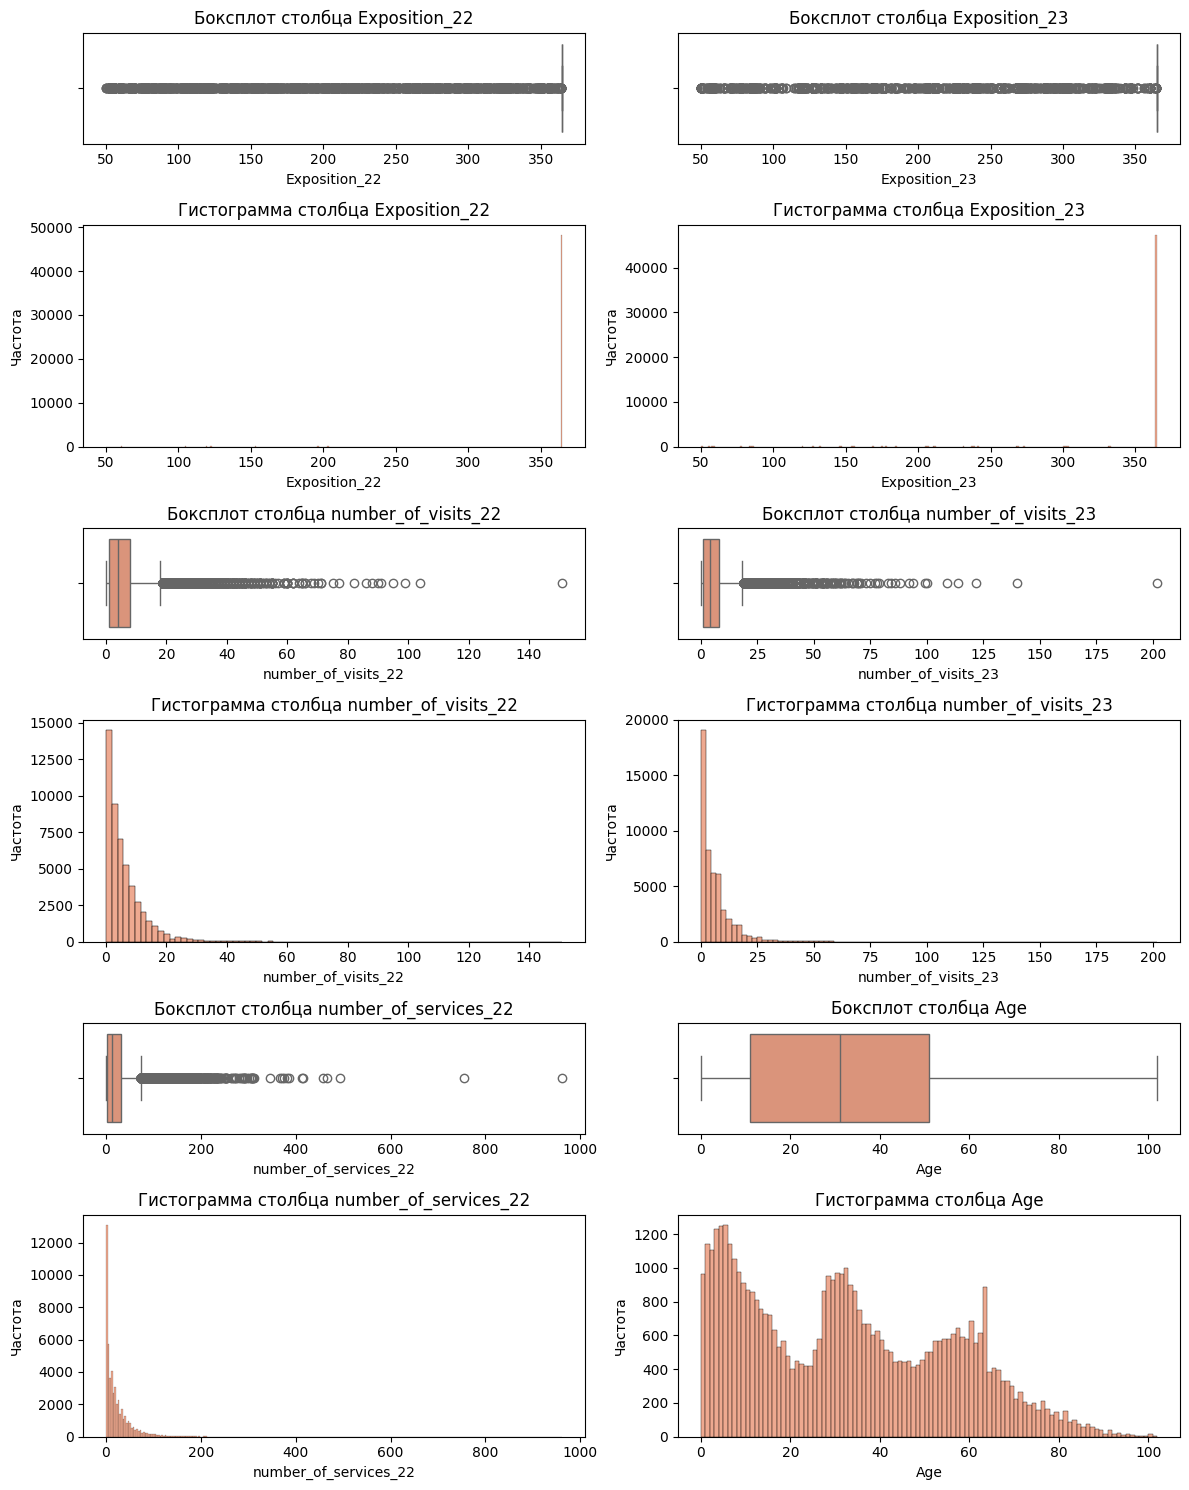

In [24]:
columns_list = ['Exposition_22', 'Exposition_23', 'number_of_visits_22',  'number_of_visits_23', 'number_of_services_22', 'Age']

plot_boxplot_and_histogram_multiple(df, columns_list)

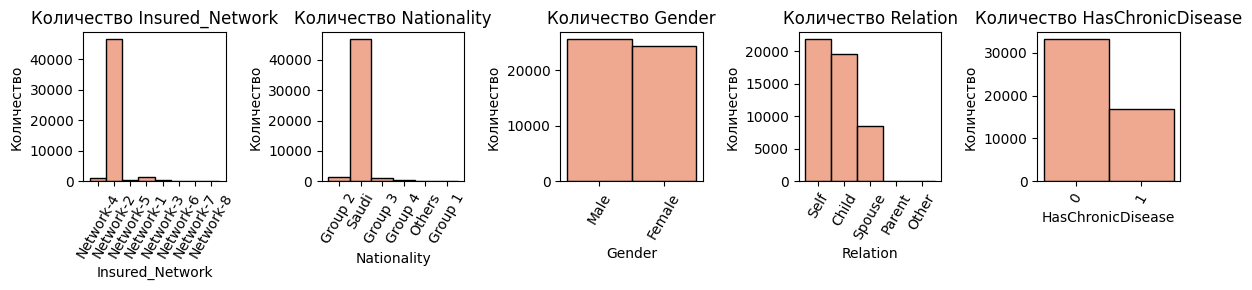

<Figure size 1500x500 with 0 Axes>

In [25]:
categorical_columns = ['Insured_Network', 'Nationality', 'Gender', 'Relation', 'HasChronicDisease']

plot_histogram(df, categorical_columns, num_features=False)

Числовые столбцы:
* Значения в столбцах `Exposition_22` и `Exposition_23` действительно почти полностью составляют `365`, что говорит о малой информативности этих столбцов. **Предположение 1: удаление `Exposition_22` и `Exposition_23` позволит точнее определять количество посещений**.
* Распределения в `number_of_visits_22` и `number_of_visits_23`, `number_of_services_22` выглядят адекватно и имеют вид экспоненциальных распределений, однако всё же стоит отметить большое количество выбросов. **Предположение 2: удаление выбросов позволит точнее определять количество посещений**.
* А вот `Age` выглядит интереснее, с пикам в примерно 8, 32 и 58 лет, то есть каждые 24 года возраста. Сделаем отметку, чтобы поинтересоваться, с чем это связано. Медианный возраст - **31** год.

Категориальные столбцы:
* В `Insured_Network` сильно преобладает `Network-2`, клиники с почти наивысшем уровнем сервиса. 
* В `Nationality` сильно преобладает `Saudi`. Мы действительно имеем дело с правящаей королевской династией в Саудовской Аравии? Наверно это объясняет предыдущий вопрос)
* Так же в этих столбцах наблюдается значительный дисбаланс по классам, почти все объекты принадлежат одному классу, возможно столбцы окажутся не информативными. **Предположение 3: удаление `Insured_Network` и `Nationality` позволит точнее определять количество посещений**.
* По гендеру почти нет различий, мужчины и женщины представлены одинаково.
* Чаще всего страховку берут на себя и на детей, значительно реже для супругов и почти никогда для родителей.
* Треть застрахованных имеет хронические болезни, две трети - нет.

Отдельно посмотрим на признак `Diagnoses`.

In [26]:
Diagnoses_df = df['Diagnoses'].to_frame()
Diagnoses_df['Diagnoses_list'] = Diagnoses_df['Diagnoses'].str.split(';').fillna(-1)
Diagnoses_all = Diagnoses_df['Diagnoses_list'].explode()
diagnoses_counts = Diagnoses_all.value_counts()

diagnoses_counts.head(10)

Diagnoses_list
J06.9    9649
-1       8774
J00      8337
J02      7370
J20      6638
J06      5007
J03      4787
E11      4468
R10      4169
J45      3942
Name: count, dtype: int64

In [27]:
Diagnoses_df['Diagnoses_len'] = Diagnoses_df['Diagnoses_list'].apply(lambda x: len(x) if type(x) is list else 0)
Diagnoses_df['Diagnoses_len'].mean()

5.66714

In [28]:
Diagnoses_df['Diagnoses_unique_group'] = Diagnoses_df['Diagnoses'].apply(count_unique_chars)
Diagnoses_df.head()

,Diagnoses,Diagnoses_list,Diagnoses_len,Diagnoses_unique_group
0,-1,-1,0,0
1,J20.9;J02,"[J20.9, J02]",2,0
2,J03.9,[J03.9],1,0
3,E56.9;J02;J00,"[E56.9, J02, J00]",3,0
4,-1,-1,0,0


**6224** уникальных диагноза, при этом многие встречаются по несколько тысяч раз, хотя средняя длина - **5.66**, а среднее количество уникальных групп диагнозов - **3.18**. Самые популярные диагнозы - с индексом `J`, заболевания дыхательной системы. Самый простой способ использовать этот признак - **использовать для каждого объекта длину и количество уникальных групп диагнозов**. Так же можно рассмотреть более сложный подход - **tf-idf**. Обозначим эти предположения как **Предположение 4** и **Предположение 5**.

Теперь посмотрим на целевой признак при группировке по каждому признаку. Для числовых признаков построим `regplot`, для категориальных таблицу с группировкой и оценкой `mean`, `std`, и `count` целевого признака для каждой группы. Так же для числовых признаков сократим диапазоны значений, чтобы сфокусировать графики в более населённой объектами области.

In [29]:
df_no_outliers = df[(df.number_of_visits_23 < 40) & (df.number_of_visits_22 < 40) & (df.number_of_services_22 < 150)]

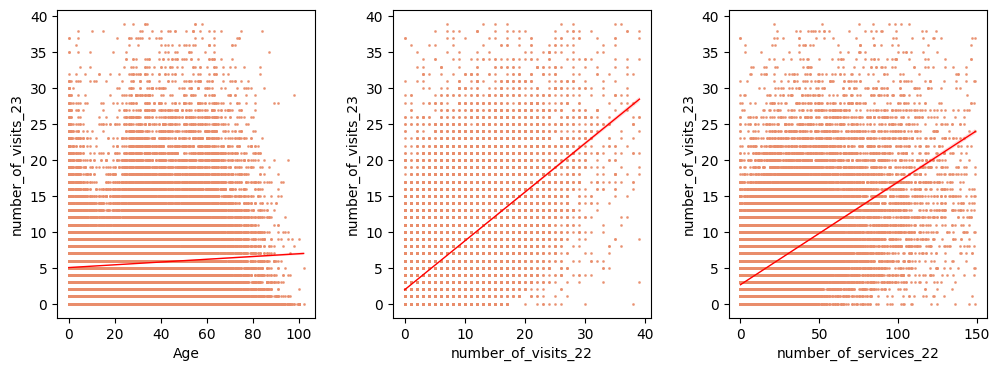

In [30]:
columns_to_regplot = ['Age', 'number_of_visits_22', 'number_of_services_22']

regplots(df_no_outliers, columns_to_regplot)

In [31]:
target_agg(df, 'Insured_Network')

,Insured_Network,mean_visits,std_visits,count_visits
0,Network-1,6.943345,7.396106,1465
1,Network-2,5.937947,6.895859,46557
2,Network-3,5.203571,5.722181,280
3,Network-4,4.480749,5.089398,961
4,Network-5,3.927562,4.836079,566
5,Network-6,1.785124,2.353036,121
6,Network-7,2.454545,2.757270,44
7,Network-8,1.333333,1.751190,6


In [32]:
target_agg(df, 'Nationality')

,Nationality,mean_visits,std_visits,count_visits
0,Group 1,3.326360,3.880864,239
1,Group 2,4.857756,5.461184,1399
2,Group 3,6.468525,6.287079,1112
3,Group 4,6.833876,6.550090,307
4,Others,6.311741,6.612072,247
5,Saudi,5.921321,6.916724,46696


In [33]:
target_agg(df, 'Gender')

,Gender,mean_visits,std_visits,count_visits
0,Female,6.232839,7.013049,24416
1,Male,5.580128,6.689101,25584


In [34]:
target_agg(df, 'Relation')

,Relation,mean_visits,std_visits,count_visits
0,Child,4.531011,5.031727,19574
1,Other,9.307692,8.053666,26
2,Parent,9.869565,9.230565,69
3,Self,6.366500,7.708415,21839
4,Spouse,7.806406,7.491555,8492


In [35]:
target_agg(df, 'HasChronicDisease')

,HasChronicDisease,mean_visits,std_visits,count_visits
0,0,4.016131,5.107323,33103
1,1,9.587323,8.214590,16897


Числовые столбцы:
* С возрастом наблюдается небольшое увеличение количества посещений.
* Однако с `number_of_visits_22` и `number_of_services_22` наблюдается более сильная связь.

Категориальные столбцы:
* Чаще всего пользуются услугами ДМС те, кто пользуются клиниками с наивысшим уровнем сервиса `Network-1`, в среднем **6.9** визитов в год. Самая популярная группа `Network-2` имеет в среднем **5.9** визитов в год. Чем хуже уровень обслуживания - тем меньше и посещений, и разброс количества посещений от среднего. Иными словами, по идее, проще всего прогнозировать количество посещений для клиник с невысоким уровнем сервиса. **Возможно этот признак несёт полезную информацию**.
* С национальностями ситуация немного отличается: `Group 3`, `Group 4`, `Other` и самая большая группа `Saudi` практически не отличаются по среднему и стандартному отклонению - около **6.5 визитов в год**.
* Женщины обращаются за услугами ДМС немного чаще мужчин - **6.2** и **5.6** визитов в год соответственно.
* Группа "дети застрахованного лица" значительно реже пользуется услугами ДМС: **4.5** визита в год, против **6.3** визитов для застрахованных работников организации и **7.8** визитов для застрахованных супругов.
* С хроническими заболеваниями пациенты посещают клинику значительно чаще, чем без них - **9.6** раз в год в среднем против **4** раз в год соответственно. При этом за счёт большего среднего отклонения максимальное количество посещений может быть значительно больше.

Перед подготовкой к **ML** части осталось построить матрицу корреляций.

interval columns not set, guessing: ['HasChronicDisease', 'Exposition_22', 'number_of_visits_22', 'number_of_services_22', 'Exposition_23', 'number_of_visits_23', 'Age']


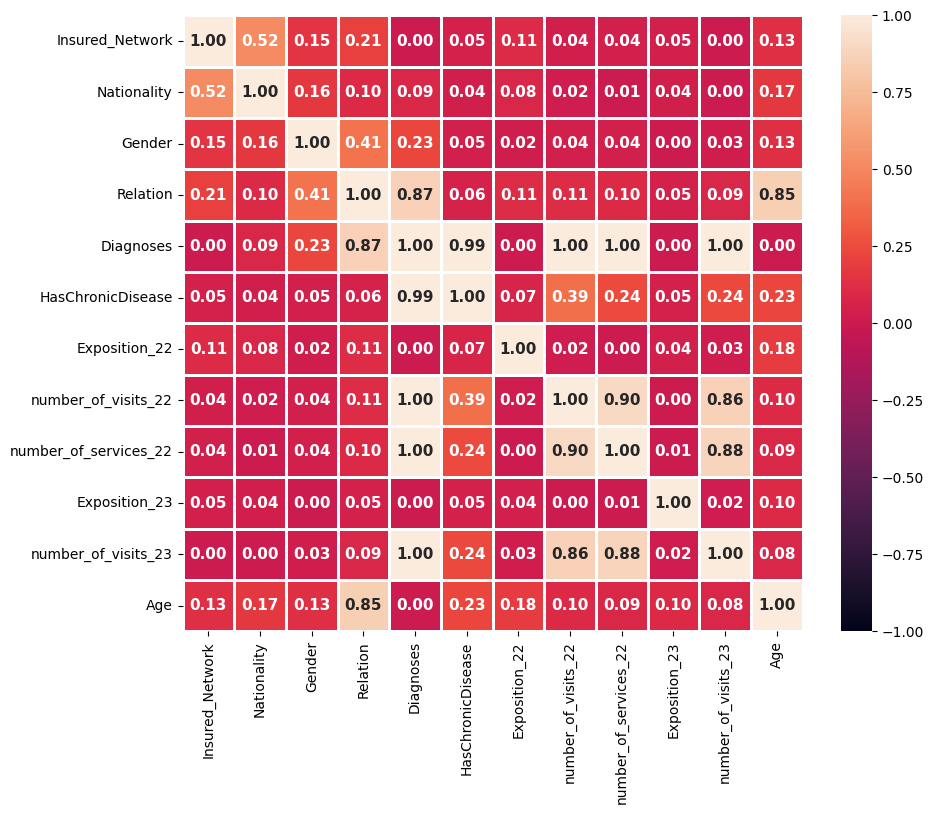

In [36]:
heatmap(df)

* Ожидаемо, что сильно коррелируют `number_of_visits_22`, `number_of_services_22` и `number_of_visits_23`.
* Так же довольно сильняя корреляция между `Relation` и `Age`, что тоже вполне понятно.
* Однако интересно, что `Diagnoses` имеет сильную корреляцию с некоторыми признаками. В чём причина - затрудняюсь ответить, возможно проблема в его формате.
* С целевой переменной не коррелируют `Insured_Network` и `Nationality`. `Exposition_22` `Exposition_23` можно сказать тоже. **Предположения 1 и 3** получают некоторое подтверждение.

Отбрасывать признаки на основе мультиколлинеарности не будем, так как планируем использовать не только линейные модели. Приступим к **ML**.

## ML  <a class="anchor" id="мл"></a>

По итогам этого раздела мы хотим получить ответ на два вопроса: какие подходы к данным и какие модели покажут наилучшие метрики.

### Подготовка данных  <a class="anchor" id="по_да"></a>

Подготовим данные. Для этого создадим рабочий `df_work`, из которого удалим необработанный столбец `Diagnoses` и выделим тренировочную и валидационную выборки. В дальнейшем будем работать с двумя метриками: метрика на кросс-валидации на тренировочной выборке и метрика на валидационной. К валидационной выборке мы не будем применять некоторые изменения, на ней мы хотим получить максимально приближенную к `holdout` оценку.

In [37]:
df_work = df.copy()
df_work.drop(['Diagnoses'], axis=1, inplace=True)

In [38]:
X = df_work.drop('number_of_visits_23', axis=1)
y = df_work['number_of_visits_23']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE)

Проверим как разбился наш тагрет на выборки.

In [40]:
y_train.mean(), round(y_train.std(), 4)

(5.9162, 6.9443)

In [41]:
y_val.mean(), round(y_val.std(), 4)

(5.8584, 6.6486)

Отличие на уровне погрешности. 

В качестве моделей будем использовать простую `LinearRegression`, посложнее `RandomForestRegressor` и замечательный `LGBMRegressor`. Построим на их основе пайплайны, в которые будет включена предобработка данных для этих моделей. Более подробно про пайплайны можно почитать [в этом проекте](https://github.com/pzae/Test_tasks_and_mini_projects/blob/main/Pet_OOP/Pet_OOP.ipynb), созданном мною.

### Подготовка пайплайнов <a class="anchor" id="по_па"></a>

In [42]:
data_transformer = CustomColumnTransformer()

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
standard_scaler = StandardScaler()

model_LR = LinearRegression()

In [43]:
categorical_transformer_LR = Pipeline(steps=[
            ('OneHotEncoder', one_hot_encoder)
    ])          
        
numerical_transformer_LR = Pipeline(steps=[
            ('StandardScaler', standard_scaler)
    ])
        
preprocessor_LR = ColumnTransformer(
        transformers=[
            ("preprocessor_cat", categorical_transformer_LR, data_transformer.cat_feature),
            ("preprocessor_num", numerical_transformer_LR, data_transformer.num_feature),
        ]
    )
    
pipeline_LR = Pipeline(
        steps=[
            ("data_transformer", data_transformer),
            ("preprocessor", preprocessor_LR),
            ("reg", model_LR),
        ]
    )

pipeline_LR

Pipeline(steps=[('data_transformer', CustomColumnTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <bound method CustomColumnTransformer.cat_feature of CustomColumnTransformer()>),
                                                 ('preprocessor_num',
                                                  Pipeline(steps=[('StandardScaler',
                                                                   StandardScaler())]),
                                                  <bound method CustomColumnTransformer.num_feature of CustomColumnTransformer()>)])),
                ('reg', LinearRegression())])

In [44]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

model_RFR = RandomForestRegressor(random_state=RANDOM_STATE)

In [45]:
categorical_transformer_RFR = Pipeline(steps=[
            ('OrdinalEncoder', ordinal_encoder),
    ])

preprocessor_RFR = ColumnTransformer(
        transformers=[
            ("preprocessor_cat", categorical_transformer_RFR, data_transformer.cat_feature)
        ],
        remainder="passthrough",
    )

pipeline_RFR = Pipeline(
        steps=[
            ("data_transformer", data_transformer),
            ("preprocessor", preprocessor_RFR),
            ("reg", model_RFR),
        ]
    )

pipeline_RFR

Pipeline(steps=[('data_transformer', CustomColumnTransformer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('preprocessor_cat',
                                                  Pipeline(steps=[('OrdinalEncoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <bound method CustomColumnTransformer.cat_feature of CustomColumnTransformer()>)])),
                ('reg', RandomForestRegressor(random_state=654321))])

In [46]:
model_LGBM = LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)

In [47]:
transformer_LGBM = FunctionTransformer(data_transformer.to_category)
    
pipeline_LGBM = Pipeline(
        steps=[
            ('transformer', transformer_LGBM),
            ("reg", model_LGBM),
        ]
    )

pipeline_LGBM

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<bound method CustomColumnTransformer.to_category of CustomColumnTransformer()>)),
                ('reg', LGBMRegressor(random_state=654321, verbose=-1))])

Пайплайны готовы, посчитаем базовое значение метрики.

### baseline <a class="anchor" id="бэ"></a>

Поместим наши модели в словарь с краткими их названиями, который нужен для функции `hypothesis_check` и создадим датафрейм `results` в который будем заносить результаты проверки каждого предположения.

In [48]:
pipelines = {'LR': pipeline_LR,
             'RFR': pipeline_RFR,
             'LGBM': pipeline_LGBM}

results = pd.DataFrame()

Посчитаем метрику на базовой выборке.

In [49]:
results = hypothesis_check(pipelines, X_train, y_train, X_val, y_val, 'baseline', results)

In [50]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75


`RandomForestRegressor` показывает худшие результаты, при этом он обучается дольше всего. `LinearRegression` и `LGBMRegressor` идут вровень. Приступим к проверке предположений.

Сначала мы хотели проверить удаление `Exposition_22` и `Exposition_23`.

### Предположение 1: удаление `Exposition_22` и `Exposition_23` позволит точнее определять количество посещений. <a class="anchor" id="п1"></a>

In [51]:
cols_to_del = ['Exposition_22', 'Exposition_23']

In [52]:
results = hypothesis_check(pipelines, X_train.drop(cols_to_del, axis=1), y_train, X_val.drop(cols_to_del, axis=1), y_val, 'drop_Exposition', results)

In [53]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64


Метрика заметно ухудшилась, предположение не подтвердилось. Интересно, как такие однородные признаки могут быть полезны. Стоит расширить анализ по этим признакам, видимо в них есть полезная информация. Оставим их. Следующий шаг: удаление выбросов в тренировочной выборке.

### Предположение 2: удаление выбросов позволит точнее определять количество посещений <a class="anchor" id="п2"></a>

In [54]:
df_train_no_outliers = X_train.join(y_train).copy()

df_train_no_outliers = df_train_no_outliers[
    (df_train_no_outliers.number_of_visits_23 < 40)
    & (df_train_no_outliers.number_of_visits_22 < 40)
    & (df_train_no_outliers.number_of_services_22 < 150)
]

In [55]:
X_train_no_outliers = df_train_no_outliers.drop('number_of_visits_23', axis=1)
y_train_no_outliers = df_train_no_outliers['number_of_visits_23']

In [56]:
X_train_no_outliers.shape[0], X_train.shape[0]

(34641, 35000)

Удалили всего 359 объектов.

In [57]:
results = hypothesis_check(pipelines, X_train_no_outliers, y_train_no_outliers, X_val, y_val, 'drop_outliers', results)

In [58]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39


Метрика на кросс-валидации выросла заметно, что говорит о том, что объекты с выбросами действительно хуже поддаются предсказанию. Однако метрика на валидацинной выборке улучшилась не так оптимистично, так как в этоq выборке остались выбросы. Всё же это улучшение, внесём его в финальную версию.

### Предположение 3: удаление `Insured_Network` и `Nationality` позволит точнее определять количество посещений <a class="anchor" id="п3"></a>

In [59]:
cols_to_del_2 = ['Insured_Network', 'Nationality']

In [60]:
results = hypothesis_check(pipelines, X_train.drop(cols_to_del_2, axis=1), y_train, X_val.drop(cols_to_del_2, axis=1), y_val, 'drop_Network_Nationality', results)

In [61]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77


Метрика меняется в рамках погрешности, хотя ожидалось хоть какое-то влияние. Что ж, оставим признаки.

### Предположение 4: использование `Diagnoses` позволит точнее определять количество посещений <a class="anchor" id="п4"></a>

In [62]:
X_train_Diagnoses, X_val_Diagnoses = X_train.copy(), X_val.copy()

X_train_Diagnoses[['Diagnoses_len', 'Diagnoses_unique_group']]  = Diagnoses_df[['Diagnoses_len', 'Diagnoses_unique_group']]
X_val_Diagnoses[['Diagnoses_len', 'Diagnoses_unique_group']]  = Diagnoses_df[['Diagnoses_len', 'Diagnoses_unique_group']]

In [63]:
results = hypothesis_check(pipelines, X_train_Diagnoses, y_train, X_val_Diagnoses, y_val, 'add_diagnoses_info', results)

In [64]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77
add_diagnoses_info,25.02,22.70,27.70,25.35,25.21,22.72


Метрика для `RandomForestRegressor` улучшилась значительно, но всё равно не дотягивает до остальных. У `LinearRegression` и `LGBMRegressor` метрики меняются в рамках погрешности, но всё же стабильно в лучшую сторону. Добавим эти признаки в финальную версию.

### Предположение 5: применение tf-idf к `Diagnoses` позволит точнее определять количество посещений <a class="anchor" id="п5"></a>

Применим `tf-idf` к `Diagnoses`. При этом установим ограничение фичей в 400, так как большинство встречается довольно редко. Так же уберем `RandomForestRegressor` из этого предположения, так как он очень долго обучается.

In [65]:
df_tf_idf = df.copy()
df_tf_idf['text_column'] = df_tf_idf['Diagnoses'] .str.replace(r';s*', ' ', regex=True).str.strip()

In [66]:
vectorizer = TfidfVectorizer(max_features=400)
tfidf_matrix = vectorizer.fit_transform(df_tf_idf["text_column"].fillna("unknown"))
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_tf_idf["text_column"].index,
)

In [67]:
X_train_tf_idf, X_val_tf_idf = X_train.copy(), X_val.copy()

X_train_tf_idf = X_train_tf_idf.merge(tfidf_df, left_index=True, right_index=True)
X_val_tf_idf = X_val_tf_idf.merge(tfidf_df, left_index=True, right_index=True)

In [68]:
pipelines_tf_idf = {'LR': pipeline_LR,
                    'LGBM': pipeline_LGBM}

In [69]:
results = hypothesis_check(pipelines_tf_idf, X_train_tf_idf, y_train, X_val_tf_idf, y_val, 'add_diagnoses_tf-idf', results)

In [70]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77
add_diagnoses_info,25.02,22.70,27.70,25.35,25.21,22.72
add_diagnoses_tf-idf,24.91,22.32,NaN,NaN,24.85,22.72


Хоть `tf-idf` и улучшил метрику, принято решение не включать его в лучшие фичи. Остался последний метод работы с данными - логарифмирование целевой переменной.

### Предположение 6: логарифмированние целевой переменной <a class="anchor" id="п6"></a>

**Данный раздел дописывался в конце работы, немного нарушена логика - сначала проверка на ошибки и обнаружение гетероскедастичности, потом логарифмирование таргета, но на перекомпановку не осталось времени.**

Попробуем помочь моделям, выдав им логарифмированный таргет. Создадим трансформер целевой переменной и немного подкорректируем пайплайны. Данный подход так же описан [в этом проекте](https://github.com/pzae/Test_tasks_and_mini_projects/blob/main/Pet_OOP/Pet_OOP.ipynb).

In [71]:
def safe_log(y):
    """
    Применяет логарифм к значению или возвращает 0, если значение равно 0.

    Параметры:
    - y: float - входное значение
    
    Возвращает:
    - float - логарифм значения или 0, если значение равно 0
    """
    return np.log(y) if y > 0 else 0

In [72]:
class TargetLog():
    """
    Класс TargetLog предназначен для логарифмирования и декодирования целевой переменной.
    Он позволяет повышать устойчивость моделей к выбросам и улучшает их предсказательную способность 
    при наличии несимметричного распределения целевой переменной.
    """
    
    def fit_resample(self, X, y):
        """
        Обучает кодировщик на целевой переменной y и выполняет её логарифмирование.

        Параметры:
        X : pd.DataFrame или np.ndarray
            Массив признаков, которые используются в модели.
        y : pd.Series или np.ndarray
            Целевая переменная, которую необходимо закодировать.

        Возвращает:
        X : pd.DataFrame или np.ndarray
            Неизмененный массив признаков.
        y_log : pd.Series или np.ndarray
            Логарифмированная целевая переменная.
        """
        y_log = y.apply(safe_log)
        return X, y_log
    
    def inverse_transform_target(self, y_log):
        """
        Декодирует логарифмированную целевую переменную обратно в исходные значения.

        Параметры:
        y_log : pd.Series или np.ndarray
            Логарифмированная целевая переменная.

        Возвращает:
        np.ndarray
            Исходные значения целевой переменной.
        """
        return np.exp(y_log)

In [73]:
class PipelineLog(Pipeline):
    """
    Класс PipelineLog представляет собой настраиваемую версию класса Pipeline, специально 
    разработанную для работы с логарифмированной целевой переменной.

    Этот класс добавляет метод `predict`, который возвращает декодированные предсказания 
    целевой переменной из логарифмированных значений, полученных от модели.
    """
    
    def predict(self, X):
        """
        Предсказывает целевую переменную для входных данных X с использованием модели,
        декодируя логарифмированные предсказания обратно в исходные значения целевой переменной.

        Parameters:
        X : pd.DataFrame или np.ndarray
            Массив признаков, используемый для предсказания.

        Returns:
        y_pred : np.ndarray
            Декодированные предсказания целевой переменной в исходных значениях.
        """
        
        y_pred_log = super().predict(X)
        y_pred = np.exp(y_pred_log)
        return y_pred

In [74]:
target_log = TargetLog()

Соберём новые пайплайны.

In [75]:
pipeline_LR_log = PipelineLog(
        steps=[
            ("data_transformer", data_transformer),
            ("preprocessor", preprocessor_LR),
            ('target_encode', target_log),
            ("reg", model_LR),
        ]
    )

In [76]:
pipeline_RFR_log = PipelineLog(
        steps=[
            ("data_transformer", data_transformer),
            ("preprocessor", preprocessor_RFR),
            ('target_encode', target_log),
            ("reg", model_RFR),
        ]
    )

In [77]:
pipeline_LGBM_log = PipelineLog(
        steps=[
            ('transformer', transformer_LGBM),
            ('target_encode', target_log),
            ("reg", model_LGBM),
        ]
    )

In [78]:
pipelines_log = {'LR': pipeline_LR_log,
                 'RFR': pipeline_RFR_log,
                 'LGBM': pipeline_LGBM_log}

In [79]:
results = hypothesis_check(pipelines_log, X_train, y_train, X_val, y_val, 'log target', results)

In [80]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77
add_diagnoses_info,25.02,22.70,27.70,25.35,25.21,22.72
add_diagnoses_tf-idf,24.91,22.32,NaN,NaN,24.85,22.72
log target,13242919.31,262.98,29.49,26.15,26.81,23.88


Лучше не стало. Линейная регрессия и вовсе испортилась (интересно почему). Жаль. Работа с данным закончена. Создадим отдельные выборки, к которым применим лучшие наши методы, с ними и будем дальше работать: отбросим выбросы в тренировочной выборке и добавим информацию о диагнозах.

In [81]:
X_train_best, y_train_best, X_val_best, y_val_best = X_train_no_outliers.copy(), y_train_no_outliers.copy(), X_val.copy(), y_val.copy()

X_train_best[['Diagnoses_len', 'Diagnoses_unique_group']]  = Diagnoses_df[['Diagnoses_len', 'Diagnoses_unique_group']]
X_val_best[['Diagnoses_len', 'Diagnoses_unique_group']]  = Diagnoses_df[['Diagnoses_len', 'Diagnoses_unique_group']]

In [82]:
results = hypothesis_check(pipelines, X_train_best, y_train_best, X_val_best, y_val_best, 'best_data', results)

In [83]:
results 

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77
add_diagnoses_info,25.02,22.70,27.70,25.35,25.21,22.72
add_diagnoses_tf-idf,24.91,22.32,NaN,NaN,24.85,22.72
log target,13242919.31,262.98,29.49,26.15,26.81,23.88
best_data,19.34,22.64,21.27,24.82,18.94,22.28


Плюс четыре десятых на валидационной выборке. Жаль, что это не задача классификации.. Но работа не окончена, мы опробовали все подходы к данным, теперь поработаем с моделями.

### Предположение 7: создание ансамбля <a class="anchor" id="п7"></a>

Попробуем следующий подход: разбить по интервалам признака датафрейм и обучить для каждой выборки свою модель. То есть мы предполагаем, что в каждой такой выборке клиенты немного отлчиаются, и мы хотим получить ансамбль моделей, каждая из которых лучше справляется со своими клиентами. Для деревянных моделей такой подход вряд ли окажется эффективным (мы просто делаем разбиение за дерево), а для линейной регрессии вполне можно ожидать улучшения результата. Плюс интересный опыт по написанию своих моделей.

Нам нужен класс, который имеет методы `__init__`, `fit` и `predict`. Таким образом он будет практически полноценной моделью, которую можно передавать в `cross_valiadate`. При инициализации будем передавать в него модель, интервал и столбец, по которому будет происходить разбиение, плюс добавим в него два атрибута `train_counts` и `test_counts` для проверки того, как выполнено разбиение на выборки.

In [84]:
class EnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model=None, intervals=None, col=None):
        """
        Инициализация ансамблевого регрессора.

        Параметры
        ----------
        model : объект
            Модель для обучения (по умолчанию LinearRegression).
        intervals : list
            Список интервалов для разбивки данных.
        col : str
            Имя столбца из X, по которому проводить разбиение данных на группы.
        """
        self.model = model if model is not None else LinearRegression()
        self.intervals = intervals
        self.col = col
        self.models = []
        self.train_counts = {}
        self.test_counts = {}

    def fit(self, X, y):
        """
        Обучение моделей на данных.
    
        Параметры
        ----------
        X : DataFrame или ndarray, shape (n_samples, n_features)
            Массив входных данных, где каждая строка представляет собой отдельный пример, 
            а каждая колонка - отдельный признак. Важным является, что один из признаков 
            соответствует `self.col`, по которому будет происходить разбиение данных на группы.
            
        y : ndarray, shape (n_samples,)
            Массив целевых значений (меток), соответствующий входным данным X. 
            Должен содержать одно значение для каждого примера в X.
    
        Примечания
        ----------
        Метод разбивает данные на несколько групп в зависимости от заданных интервалов и
        обучает отдельные модели на каждой из этих групп. В результате для каждого интервала
        будет своя модель. Если в интервал не попадает ни одно значение, модель для этого интервала
        не будет обучена.
    
        В процессе работы метод также заполняет словарь `self.train_counts`, который хранит
        количество примеров, использованных для обучения в каждом интервале.
        """
        y = np.array(y)

        self.train_counts = {f'({start}, {end})': 0 for start, end in self.intervals}

        for start, end in self.intervals:
            mask = (X[self.col] >= start) & (X[self.col] < end)
            X_group = X[mask]
            y_group = y[mask]

            if len(y_group) > 0:
                model_clone = clone(self.model)
                model_clone.fit(X_group, y_group)
                self.models.append((start, end, model_clone))
                self.train_counts[f'({start}, {end})'] = mask.sum()

    def predict(self, X):
        """
        Предсказание на новых данных.
    
        Параметры
        ----------
        X : DataFrame, shape (n_samples, n_features)
            Датафрейм входных данных, для которых необходимо сделать предсказание.
            Как и в методе fit, важно, чтобы один из признаков соответствовал `self.col`,
            по которому будет происходить разбиение данных на группы.
    
        Возвращает
        ----------
        predictions : ndarray, shape (n_samples,)
            Массив предсказанных значений для входных данных X. Для каждого примера
            в X будет возвращено соответствующее предсказанное значение. Если пример
            попадает в интервал, где нет обученной модели, то предсказание будет равно 0.
    
        Примечания
        ----------
        Метод проходит по всем интервалам, для которых были обучены модели, и для каждого
        интервала делает предсказания для примеров, попадающих в этот интервал. Результат
        собирается в один массив, который затем возвращается в качестве итоговых предсказаний.
        Также в процессе работы метод заполняет словарь `self.test_counts`, который хранит
        количество примеров, использованных для предсказания в каждом интервале.
        """
        predictions = np.zeros(X.shape[0])
        self.test_counts = {f'({start}, {end})': 0 for start, end in self.intervals}

        for start, end, model in self.models:
            mask = (X[self.col] >= start) & (X[self.col] < end)
            if mask.any():
                preds = model.predict(X[mask])
                predictions[mask] = preds
                self.test_counts[f'({start}, {end})'] = mask.sum()

        return predictions

Применим данный метод к двум столбцам: `Age` и `number_of_visits_22`. Для `Age` возьмём не равномерные по количеству объектов интервалы, а примерно те, границы которых соответствуют минимумам между горбами на гистограмме, плюс небольшой хвост, благо объектов достаточно, чтобы на выборке из хвоста модели смогли обучиться. Создадим `EnsembleRegressor` на основе наших пайплайнов и передадим их в словарь `EnsembleRegressors` с теми же ключами, чтобы поместить результаты в нашу таблицу `result`.

In [85]:
intervals = [(0, 22), (22, 45), (45, 70), (70, 102)]
col = 'Age'

EnsembleRegressor_LR = EnsembleRegressor(model=pipeline_LR, intervals=intervals, col=col)
EnsembleRegressor_RFR = EnsembleRegressor(model=pipeline_RFR, intervals=intervals, col=col)
EnsembleRegressor_LGBM = EnsembleRegressor(model=pipeline_LGBM, intervals=intervals, col=col)

EnsembleRegressors = {'LR': EnsembleRegressor_LR,
                      'RFR': EnsembleRegressor_RFR,
                      'LGBM': EnsembleRegressor_LGBM}

In [86]:
results = hypothesis_check(EnsembleRegressors, X_train_best, y_train_best, X_val_best, y_val_best, 'EnsembleRegressor_Age', results)

In [87]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77
add_diagnoses_info,25.02,22.70,27.70,25.35,25.21,22.72
add_diagnoses_tf-idf,24.91,22.32,NaN,NaN,24.85,22.72
log target,13242919.31,262.98,29.49,26.15,26.81,23.88
best_data,19.34,22.64,21.27,24.82,18.94,22.28
EnsembleRegressor_Age,19.15,22.35,21.55,25.14,19.79,23.31


In [88]:
train_counts = EnsembleRegressor_LR.train_counts
test_counts = EnsembleRegressor_LR.test_counts

In [89]:
print("Количество объектов в интервалах для тренировочных данных:")
print(train_counts)
print("\nКоличество объектов в интервалах для тестовых данных:")
print(test_counts)

Количество объектов в интервалах для тренировочных данных:
{'(0, 22)': 13093, '(22, 45)': 10801, '(45, 70)': 8836, '(70, 102)': 1910}

Количество объектов в интервалах для тестовых данных:
{'(0, 22)': 5679, '(22, 45)': 4661, '(45, 70)': 3790, '(70, 102)': 869}


Для линейной регрессии результат стал совсем немного лучше, у нас есть новая лучшая метрика **22.35**, однако для деревянных моделей метрика заметно подросла, что, в некоторой степени, согласуется с ожиданиями. При этом разбиение на интервалы выглядит успешно. В идеале, конечно, хотелось бы посмотреть на наши модели, оценить их поотдельности (подобрать гиперпараметры...), но это уже слишком. Приступим лучше к `number_of_visits_22`. Его разобьём на равновесные по количеству объектов 4 интервала.

In [90]:
intervals = pd.qcut(df['number_of_visits_22'], q=4)
boundaries = intervals.cat.categories
boundaries_list = [(interval.left, interval.right) for interval in boundaries]

boundaries_list

[(-0.001, 1.0), (1.0, 4.0), (4.0, 8.0), (8.0, 151.0)]

В `holdout` наибольшее значение находится ниже 151, поэтому не будем заморачиваться с крайней правой границей.

In [91]:
intervals = boundaries_list
col = 'number_of_visits_22'

EnsembleRegressor_LR = EnsembleRegressor(model=pipeline_LR, intervals=intervals, col=col)
EnsembleRegressor_RFR = EnsembleRegressor(model=pipeline_RFR, intervals=intervals, col=col)
EnsembleRegressor_LGBM = EnsembleRegressor(model=pipeline_LGBM, intervals=intervals, col=col)

EnsembleRegressors = {'LR': EnsembleRegressor_LR,
                      'RFR': EnsembleRegressor_RFR,
                      'LGBM': EnsembleRegressor_LGBM}

In [92]:
results = hypothesis_check(EnsembleRegressors, X_train_best, y_train_best, X_val_best, y_val_best, 'EnsembleRegressor_NoV_22', results)

In [93]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77
add_diagnoses_info,25.02,22.70,27.70,25.35,25.21,22.72
add_diagnoses_tf-idf,24.91,22.32,NaN,NaN,24.85,22.72
log target,13242919.31,262.98,29.49,26.15,26.81,23.88
best_data,19.34,22.64,21.27,24.82,18.94,22.28
EnsembleRegressor_Age,19.15,22.35,21.55,25.14,19.79,23.31
EnsembleRegressor_NoV_22,18.84,22.08,21.35,24.94,19.36,22.76


Здесь интереснее. Линейная регрессия стала ещё лучше с показателем **22.09**, а `RandomForestRegressor` и `LGBMRegressor` (речь про ансамбли) улучшили свои показатели по отношению к `EnsembleRegressor_Age`, однако всё ещё не дотягивают до базовых моделей (пайплайнов). 

### Предположение 8: подбор гиперпараметров <a class="anchor" id="п8"></a>

Про `CustomOptuna` так же можно почитать [в этом проекте](https://github.com/pzae/Test_tasks_and_mini_projects/blob/main/Pet_OOP/Pet_OOP.ipynb). Если вкратце, она включает в себя оценку на кросс-валидации, раннюю остановку, если метрика не улучшается некоторое количество триалов, встроенные наборы гиперпараметров и, собственно, подборгиперпараметров с возможностью извлечения лучшей модели. Применять её будем только к `LGBMRegressor`. Сначала обучим на лучших данных без выбросов, проверим метрику на валидационной выборке, затем возьмём лучшие данные с выбросами.

In [94]:
from custom_optuna import CustomOptuna

In [95]:
N_TRIALS = 50
TIMEOUT = 180
INTERVAL = 20

In [96]:
custom_optuna = CustomOptuna(n_trials=N_TRIALS, timeout=TIMEOUT, cv=CV, interval=INTERVAL, random_state=RANDOM_STATE, scorer='neg_mean_squared_error')
study = custom_optuna.study_optimize(pipeline_LGBM, X_train_best, y_train_best)

  0%|          | 0/50 [00:00<?, ?it/s]

In [97]:
optuna_model = custom_optuna.objective_to_study.best_model_
optuna_model

Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<bound method CustomColumnTransformer.to_category of CustomColumnTransformer()>)),
                ('reg',
                 LGBMRegressor(bagging_fraction=0.9934972891371312,
                               bagging_freq=4,
                               feature_fraction=0.609055457218406,
                               lambda_l1=0.0005930497506225612,
                               lambda_l2=7.575699548040964e-07,
                               learning_rate=0.014374951169169356, max_depth=6,
                               min_child_samples=62, num_leaves=86,
                               random_state=654321, verbose=-1))])

In [98]:
results = hypothesis_check({'LGBM': optuna_model}, X_train_best, y_train_best, X_val_best, y_val_best, 'optuna_best_data', results)

In [99]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77
add_diagnoses_info,25.02,22.70,27.70,25.35,25.21,22.72
add_diagnoses_tf-idf,24.91,22.32,NaN,NaN,24.85,22.72
log target,13242919.31,262.98,29.49,26.15,26.81,23.88
best_data,19.34,22.64,21.27,24.82,18.94,22.28
EnsembleRegressor_Age,19.15,22.35,21.55,25.14,19.79,23.31
EnsembleRegressor_NoV_22,18.84,22.08,21.35,24.94,19.36,22.76


In [100]:
X_train_best_2, y_train_best_2, X_val_best_2 = X_train.copy(), y_train.copy(), X_val.copy()

X_train_best_2[['Diagnoses_len', 'Diagnoses_unique_group']]  = Diagnoses_df[['Diagnoses_len', 'Diagnoses_unique_group']]
X_val_best_2[['Diagnoses_len', 'Diagnoses_unique_group']]  = Diagnoses_df[['Diagnoses_len', 'Diagnoses_unique_group']]

In [101]:
study = custom_optuna.study_optimize(pipeline_LGBM, X_train_best_2, y_train_best_2)

  0%|          | 0/50 [00:00<?, ?it/s]

In [102]:
optuna_model_2 = custom_optuna.objective_to_study.best_model_

In [103]:
results = hypothesis_check({'LGBM': optuna_model_2}, X_train_best_2, y_train_best_2, X_val_best_2, y_val_best, 'optuna_best_data_2', results)

In [104]:
results

,LR_cv,LR_val,RFR_cv,RFR_val,LGBM_cv,LGBM_val
baseline,25.04,22.76,28.46,26.63,25.09,22.75
drop_Exposition,25.90,23.58,29.82,27.45,26.08,23.64
drop_outliers,19.38,22.70,22.12,25.87,18.99,22.39
drop_Network_Nationality,25.06,22.77,28.64,26.56,25.15,22.77
add_diagnoses_info,25.02,22.70,27.70,25.35,25.21,22.72
add_diagnoses_tf-idf,24.91,22.32,NaN,NaN,24.85,22.72
log target,13242919.31,262.98,29.49,26.15,26.81,23.88
best_data,19.34,22.64,21.27,24.82,18.94,22.28
EnsembleRegressor_Age,19.15,22.35,21.55,25.14,19.79,23.31
EnsembleRegressor_NoV_22,18.84,22.08,21.35,24.94,19.36,22.76


Видно, что подбор гиперпараметров на выборке без выбросов ухудшает положение, однако на выборке с выбросами `LGBMRegressor` показал второй лучший для себя результат.

Таким образом, лучшее решение выглядит так:  
Данные - Тренировочные данные без выбросов + информация о данных в `Diagnoses` (и в тестовую выборку)  
Модель - `EnsembleRegressor` на основе `pipeline_LR` с разбиением по столбцу `number_of_visits_22` на 4 равновесных по количеству объектов выборки. Оформим его, применив нужные преобразования и к `holdout` выборке.

## Финальное решение <a class="anchor" id="фи_ре"></a>

### Подготовка данных и модели <a class="anchor" id="по_да"></a>

Вынесем все действия, которые применялись к данным и проведём предобработку снова, чтобы проверить, что ничего не забыто.

In [105]:
df_work = pd.read_excel('../data/ML_train.xlsx')

In [106]:
def Diagnoses_info(df, col):

    df_work = df.copy()
    df_work['Diagnoses_list'] = df_work[col].str.split(';')
    Diagnoses_all = df_work['Diagnoses_list'].explode()
    diagnoses_counts = Diagnoses_all.value_counts()

    df_work['Diagnoses_len'] = df_work['Diagnoses_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df_work['Diagnoses_unique_group'] = df_work[col].apply(count_unique_chars)
    df_work.drop('Diagnoses_list', axis=1, inplace=True)

    return df_work

In [107]:
df_work['Age'] = 2022 - df_work.DoB.dt.year
df_work.Diagnoses.fillna(-1, inplace=True)
df_work.Age.fillna(df.Age.median(), inplace=True)
df_work = Diagnoses_info(df_work, 'Diagnoses')

df_work.drop(['Insured_PIN', 'DoB', 'Diagnoses'], axis=1, inplace=True)

In [108]:
X = df_work.drop('number_of_visits_23', axis=1)
y = df_work['number_of_visits_23']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE)

In [109]:
df_train = X_train.join(y_train)

df_train = df_train[(df_train.number_of_visits_23 < 40) & (df_train.number_of_visits_22 < 40) & (df_train.number_of_services_22 < 150)]

X_train = df_train.drop('number_of_visits_23', axis=1)
y_train = df_train['number_of_visits_23']

In [110]:
intervals = pd.qcut(df['number_of_visits_22'], q=4)
boundaries = intervals.cat.categories
boundaries_list = [(interval.left, interval.right) for interval in boundaries]
col = 'number_of_visits_22'

In [111]:
best_model = EnsembleRegressor(model=pipeline_LR, intervals=boundaries_list, col=col)

In [112]:
best_results = pd.DataFrame()

In [113]:
best_results = hypothesis_check({'best': best_model}, X_train, y_train, X_val, y_val, 'best_results', best_results)

In [114]:
best_results

,best_cv,best_val
best_results,18.84,22.08


### Важность признаков <a class="anchor" id="ва_пр"></a>

Важность признаков покажем с помощью `permutation_importance` на кросс-валидации.

In [115]:
result_pi_dict = permutation_importance_cv(best_model,
                                           X_train,
                                           y_train,
                                           cv=CV,
                                           scoring='neg_mean_squared_error',
                                           n_repeats=10,
                                           random_state=RANDOM_STATE,
                                           load_data=LOAD_DATA)

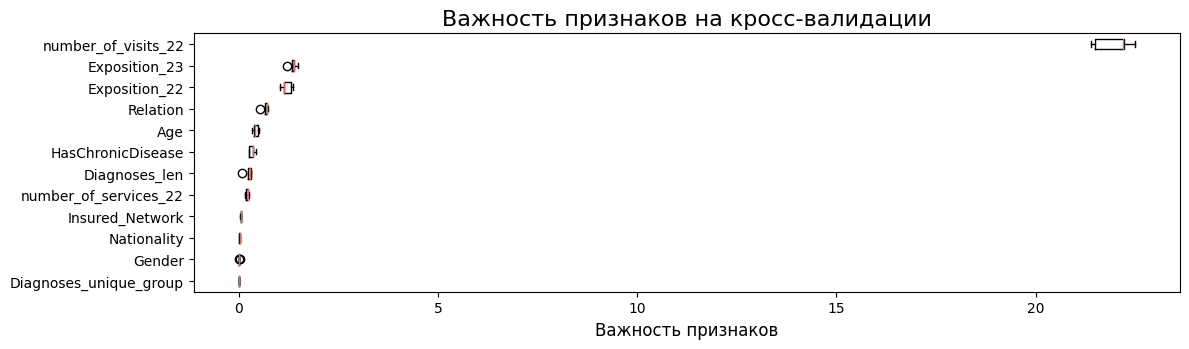

In [116]:
permutation_importance_graph(result_pi_dict, X_train)

Количество дней в 2022 году, в которые застрахованный посещал клинику для получения медицинской помощи, оказалось самым важным признаком с большим отрывом от всех остальных. При этом `Exposition_22` и `Exposition_23` на удивление показали наибольшее влияние среди всех остальных признаков.

### Анализ ошибок <a class="anchor" id="ан_ош"></a>

Отдельно обучим лучшую модель, посмотрим, как влияет округление на метрику и построим графики остатков.

In [117]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

In [118]:
y_pred_round = [round(x) for x in y_pred]

In [119]:
round(mean_squared_error(y_pred, y_val), 2), round(mean_squared_error(y_pred_round, y_val), 2)

(22.08, 22.18)

От округления до целого метрика меняется незначительно.

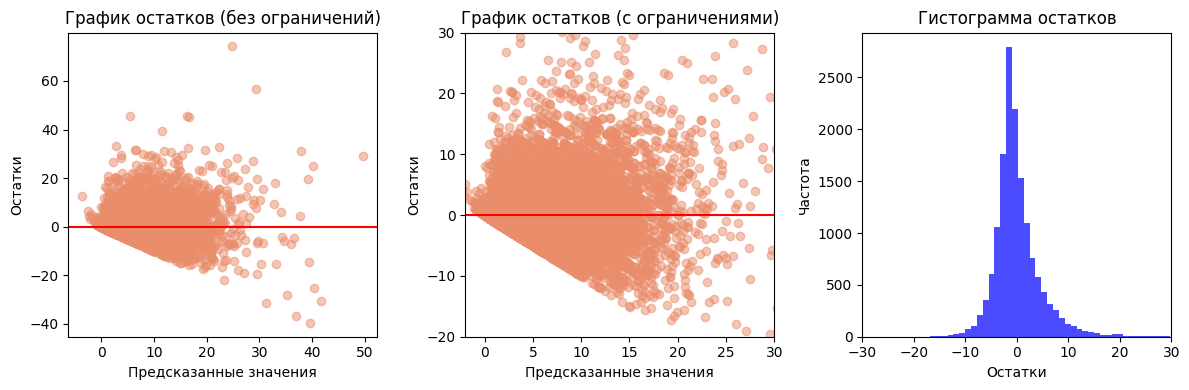

Среднее остатков: 0.0871


In [120]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_residuals(y_val, y_pred, axs[0], 'График остатков (без ограничений)')
plot_residuals(y_val, y_pred, axs[1], 'График остатков (с ограничениями)', x_lim=(-2, 30), y_lim=(-20, 30))
hist_residuals(y_val, y_pred, axs[2], x_lim=(-30, 30))
plt.tight_layout()

plt.show()

print('Среднее остатков:', round((y_val - y_pred).mean(), 4))

Наблюдается гетероскедастичность. Судя по метрикам в *предположении 6* логарифмирование целеовой переменной не помогает.
Так же видно, что предсказания модели практически несмещённые! Неужели переобучение?

In [121]:
y_pred_train = pipeline_LGBM.predict(X_train)
round(mean_squared_error(y_pred_train, y_train), 2)

16.81

Вроде нет. Интересно.

На этом закончим анализ и подготовим `holdout` выборку.

### Подготовка `holdout` выборки <a class="anchor" id="по_хо"></a>

In [122]:
df_holdout = pd.read_excel('../data/ML_holdout.xlsx')

In [123]:
df_holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            10000 non-null  int64         
 1   Insured_Network        10000 non-null  object        
 2   Nationality            10000 non-null  object        
 3   Gender                 10000 non-null  object        
 4   Relation               10000 non-null  object        
 5   DoB                    10000 non-null  datetime64[ns]
 6   Diagnoses              8274 non-null   object        
 7   HasChronicDisease      10000 non-null  int64         
 8   Exposition_22          10000 non-null  int64         
 9   number_of_visits_22    10000 non-null  int64         
 10  number_of_services_22  10000 non-null  int64         
 11  Exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 937.6

In [124]:
df_holdout_work = df_holdout.copy()

In [125]:
df_holdout_work['Age'] = 2022 - df_holdout_work.DoB.dt.year

In [126]:
df_holdout_work = Diagnoses_info(df_holdout_work, 'Diagnoses')

In [127]:
df_holdout_work.drop(['Insured_PIN', 'DoB', 'Diagnoses'], axis=1, inplace=True)

In [128]:
df_holdout_work.head()

,Insured_Network,Nationality,Gender,Relation,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age,Diagnoses_len,Diagnoses_unique_group
0,Network-2,Saudi,Female,Child,0,365,1,3,365,10,1,0
1,Network-1,Saudi,Female,Child,0,365,4,22,365,27,4,0
2,Network-2,Saudi,Female,Spouse,0,365,5,11,365,60,4,0
3,Network-2,Saudi,Male,Child,1,365,9,30,365,19,8,0
4,Network-2,Saudi,Female,Spouse,0,365,3,10,365,27,3,0


Ура, мы готовы получить предсказания, обучив модель на всей выборке без выбросов.

In [129]:
df_train_full = df_work[(df_work.number_of_visits_23 < 40) & (df_work.number_of_visits_22 < 40) & (df_work.number_of_services_22 < 150)]

X_train_full = df_train_full.drop('number_of_visits_23', axis=1)
y_train_full = df_train_full['number_of_visits_23']

In [130]:
best_model = EnsembleRegressor(model=pipeline_LR, intervals=boundaries_list, col=col)
best_model.fit(X_train_full, y_train_full)

In [131]:
pred_holdout = best_model.predict(df_holdout_work)

pred_holdout_round = [round(x) for x in pred_holdout]

In [132]:
df_holdout['predict'] = pred_holdout_round

В задании сказано "В результаты должен быть файл .csv с предсказаниями на выборке holdout с указанием ид застрахованного и предсказанием модели". Не понятно, как именно нужно указать id, в индексе, или просто в столбце. Сохраним датафрейм с двумя столбцами.

In [133]:
df_holdout[['Insured_PIN', 'predict']].set_index('Insured_PIN').to_csv('holdout_predict.csv')

## Выводы

Задача данного проекта - предсказать количество обращений застрахованных по ДМС за 2023 год на основе данных за 2022 год. Предоставленные для решения этой задачи данные содержат 50000 уникальных записей. Метрика оценки качества модели - `MSE`. Финальная оценка качества модели проводится на стороне заказчика путём передачи ему предсказаний на `holdout` выборке, содержащей 10000 объектов. 

В **Подготовке к работе** загружены нужные библиотеки, описаны функции. **Загрузка и обзор данных** показали, что данные отличного качества, один пропуск в столбце `Age`, созданном на основе `DoB`, заполнен медианой, 8 774 пропусков в столбце `Diagnoses` заполнены заглушкой `-1`. Выбросы в столбце `number_of_visits_22` решено не удалять сразу, а вынести их удаление в отдельное *предположение*. Столбцы `Insured_PIN`, `DoB` удалены как не несущие важнй информации. Подробная визуализация признаков и их связи с целевой переменной показана в **Исследовательский анализ данных**. Так же сформулированы *5 предположений о том, как можно повысить точность предсказаний* и показана матрица корреляций. Далее в исследоавнии начинается **ML** часть, открывающаяся **Подготовкой данных**, в виде выделения тренировочной и валидационной выборок. Дальнейшая оценка моделей и *предположений* выполнялась по двум метрикам: на кросс-валидации на тренировочной выборке и "прямая"на валидационной. Для этого выбраны три модели: `LinearRegression`, `RandomForestRegressor` и  `LGBMRegressor`, для которых  **Подготовлены пайплайны** предобработки данных. **Baseline** показал следующие метрики:

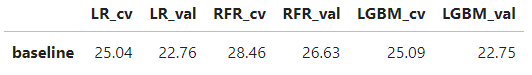

По итогам проверки *8 предположений* выбрано лучшее решение, показавшее метрики **18.84** и	**22.08** на кросс-валидации и на валидационной выборках соответственно:
  
Данные - Тренировочные данные без выбросов + информация о данных в `Diagnoses` (и в тестовую выборку)  
Модель - `EnsembleRegressor` на основе `pipeline_LR` с разбиением по столбцу `number_of_visits_22` на 4 равновесных по количеству объектов выборки. Оформим его, применив нужные преобразования и к `holdout` выборке.

**Важность признаков** показала, чо количество дней в 2022 году, в которые застрахованный посещал клинику для получения медицинской помощи, оказалось самым важным признаком с большим отрывом от всех остальных. При этом `Exposition_22` и `Exposition_23` на удивление показали наибольшее влияние среди всех остальных признаков. Исходя из **Анализа ошибок** видно, что предсказания нашей модели обладают гетероскедастичностью, что не получилось устранить логарифмированием целевой переменной, однако предсказания несмещенны относительно реальных значений.

Исследование завершает **Подготовка `holdout` выборки** для создания файла с предсказаниями для оценки на стороне заказчика. 